# Example PVPRO run with synthetic data

This notebook generates a PV dataset from an NSRDB weather data file. The dataset is generated by specifying rates of change of single diode model parameters, so the ground truth is known. The simulation adds noise to the measured module temperature and plane-of-array irradiance in order to make a more realistic dataset.

Using the sythetic data, the PVPRO method is used to extract single diode model parameters vs. time. The results are compared to the ground truth.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import numpy as np
import pandas as pd
import sys
import os

# ADD pvpro module to path.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.postprocess import analyze_yoy
from pvpro.plotting import plot_results_timeseries

from pvpro.singlediode import calculate_temperature_coeffs, pvlib_single_diode
from pvlib.temperature import sapm_module, sapm_cell

## Generate Synthetic Data

Load data

In [3]:
import inspect
import pvpro
pvpro_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvpro)))
filename =  os.path.join(pvpro_abspath,'data','NSRDB_data_compressed_123796_37.89_-122.26.npz')
data = np.load(filename)

In [4]:
df = pd.DataFrame({'dni': data['dni'],
                   'ghi': data['ghi'],
                   'temperature_air': data['temp_air'],
                   'wind_speed': data['wind_speed'],
                   'year': data['year'],
                   'month': data['month'],
                   'day': data['day'],
                   'hour': data['hour'],
                   'minute': data['minute']
                   })

df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# # Clip shorter
df = df[:'2002-01-01']

# 15 minute interpolation
df = df.resample('15T').interpolate('linear')

# drop times when GHI is <= 1
df.drop(df.index[df['ghi'] <= 1.], inplace=True)

# assume poa = ghi, e.g., horizontal module
df['poa_actual'] = df['ghi']

# Calculate true module/cell temperature
df['temperature_module_actual'] = sapm_module(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075
)

df['temperature_cell_actual'] = sapm_cell(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075,
    deltaT=3)

Simulate some noise on the "measured" poa irradiance by multiplying Gaussian noise with the "actual" poa irradiance.

In [5]:
# Fractional POA noise standard deviation. 
poa_noise_level = 0.02

# Seed random generator to get same results each time.
np.random.seed(0)
df['poa_meas'] = df['poa_actual'] * np.random.normal(1, poa_noise_level, len(df))


The "measured" module temperature is created by adding normally distributed noise to the "actual" module temperature.

In [6]:
# Temperature noise standard deviation in C.
temperature_noise_level = 1.0

df['temperature_module_meas'] = df['temperature_module_actual'] + \
        np.random.normal(0,temperature_noise_level, len(df))


In [7]:

def step_change(start_val, end_val, t_years, t_step=2):
    """
    Create a smooth step change time series. 
    """
    y = np.zeros_like(t_years) + start_val
    y = y + (end_val - start_val) * (
            np.arctan(10 * (t_years - 2)) / np.pi + 0.5)
    return y


In [8]:
q = 1.60218e-19  # Elementary charge in units of coulombs
kb = 1.38066e-23  # Boltzmann's constant in units of J/K

# time vector in years
t_years = (df.index - df.index[0]).days / 365

Set the parameters and how they change with time.

In [9]:
df['cells_in_series'] = 60
df['alpha_sc'] = 0.001
df['diode_factor'] = 1.2 - 0.0 * t_years
df['nNsVth_ref'] = df['diode_factor'] * df['cells_in_series'] * kb / q * (
        273.15 + 25)
df['photocurrent_ref'] = 6.0 - (0.1 * t_years - 0.05 * np.sin(2 * np.pi * t_years))
df['saturation_current_ref'] = 1e-10 + 0.5e-9 * t_years
# df['resistance_shunt_ref'] = step_change(1000, 100, t_years, 2)
df['resistance_shunt_ref'] = 1e12
df['conductance_shunt_extra'] = 0.000 + 0.0003 * t_years
df['resistance_series_ref'] = step_change(0.35, 0.7, t_years)
# df['resistance_series_ref'] = 0.35
df['band_gap_ref'] = 1.121
df['dEgdT'] = -0.0002677

In [10]:
# Calculate module operation over time.
out = pvlib_single_diode(
    effective_irradiance=df['poa_actual'],
    temperature_cell=df['temperature_cell_actual'],
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    Eg_ref=df['band_gap_ref'],
    dEgdT=df['dEgdT'],
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='newton',
    ivcurve_pnts=None,
)

# Add to the dataframe
for k in out.keys():
    df[k] = out[k]

# Calculate module reference conditions over time.
out_ref = pvlib_single_diode(
    effective_irradiance=1000,
    temperature_cell=25,
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    Eg_ref=df['band_gap_ref'],
    dEgdT=df['dEgdT'],
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='newton',
    ivcurve_pnts=None,
)

for k in out_ref.keys():
    df[k + '_ref'] = out_ref[k]

# Set DC operation point at MPP
df['v_dc'] = df['v_mp']
df['i_dc'] = df['i_mp']

# Change DC operation point to Voc during low irradiance conditions
df.loc[df['poa_actual'] < 50, 'v_dc'] = df.loc[
    df['poa_actual'] < 50, 'v_oc']
df.loc[df['poa_actual'] < 50, 'i_dc'] = 0


df.loc[df.index.day==1, 'v_dc'] = df.loc[df.index.day==1, 'v_oc']
df.loc[df.index.day==1, 'i_dc'] = 0


# Save data
# df.to_pickle('synth01_out.pkl')
print('done!')

done!


## Run Preprocess.

Load preprocessor

In [11]:
pre = Preprocessor(df,
                   voltage_dc_key='v_dc',
                   current_dc_key='i_dc',
                   temperature_module_key='temperature_module_meas',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   )

Calculate cell temperature from moduule temperature and POA.

In [12]:
pre.calculate_cell_temperature(delta_T=3)

Cell temperature assigned to 'temperature_cell'


Two preprocessing modes, 'fast' and 'sdt'. Since this is clean synthetic data, we will use the 'fast' pipeline.

In [13]:
method='fast'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()

Make PvProHandler object to store data and run analysis.

In [14]:
pvp = PvProHandler(pre.df,
                   system_name='synthetic',
                   cells_in_series=60,
                   resistance_shunt_ref=df['resistance_shunt_ref'].mean(),
                   alpha_isc=0.001,
                   voltage_key='v_dc',
                   current_key='i_dc',
                   temperature_cell_key='temperature_cell',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   )

In [15]:
pvp.df

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,...,seq_index,temperature_cell,power_dc,clipped_times,high_v,missing_data,no_errors,low_p,daytime,operating_cls
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,...,0,9.882439,0.0,False,True,False,True,True,False,1
1998-01-01 08:00:00,177.0,47.0,10.0,2.300781,1998.0,1.0,1.0,8.0,0.0,47.0,...,1,12.436980,0.0,False,True,False,True,True,False,1
1998-01-01 08:15:00,238.0,77.0,10.0,2.351562,1998.0,1.0,1.0,8.0,15.0,77.0,...,2,11.650855,0.0,False,True,False,True,True,False,1
1998-01-01 08:30:00,299.0,107.0,10.0,2.400391,1998.0,1.0,1.0,8.0,30.0,107.0,...,3,13.231624,0.0,False,True,False,True,True,False,1
1998-01-01 08:45:00,165.5,104.0,10.5,2.500000,1998.0,1.0,1.0,8.5,15.0,104.0,...,4,12.784768,0.0,False,True,False,True,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-01-01 15:45:00,0.0,60.5,13.0,2.750000,2002.0,1.0,1.0,15.5,15.0,60.5,...,70368,14.221421,0.0,False,True,False,True,True,False,1
2002-01-01 16:00:00,0.0,44.0,13.0,2.800781,2002.0,1.0,1.0,16.0,0.0,44.0,...,70369,12.699330,0.0,False,True,False,True,True,False,1
2002-01-01 16:15:00,0.0,30.5,13.0,2.800781,2002.0,1.0,1.0,16.0,15.0,30.5,...,70370,14.008826,0.0,False,True,False,True,True,False,1
2002-01-01 16:30:00,0.0,17.0,13.0,2.800781,2002.0,1.0,1.0,16.0,30.0,17.0,...,70371,12.666300,0.0,False,True,False,True,True,False,1


In [39]:
# Estimate startpoint.
pvp.estimate_p0(
    boolean_mask = np.logical_and.reduce(
        (pvp.df['operating_cls']==0,
        pvp.df[pvp.irradiance_poa_key]>300)
    )
)
# pvp.p0['diode_factor'] = 1.1
print('Estimated startpoint:')
print(pvp.p0)

Estimated startpoint:
{'diode_factor': 1.3455328800176904, 'photocurrent_ref': 5.962660540743577, 'saturation_current_ref': 7.473157878051913e-09, 'resistance_series_ref': 0.4298068719342463, 'resistance_shunt_ref': 400, 'conductance_shunt_extra': 0.0, 'v_oc_ref': 42.5216537621072, 'i_mp_ref': 5.560600479054517, 'i_sc_ref': 5.934153507862071, 'v_mp_ref': 34.54610657876529, 'p_mp_ref': 192.09709679135068, 'alpha_isc': 0.002980375307397469, 'alpha_imp': -0.00745244223049655, 'beta_vmp': -0.21029326536680307, 'beta_voc': -0.2054198080862189, 'cells_in_series': 60, 'nNsVth_ref': 2.0749686798232805}


Can set a custom startpoint if auto-chosen startpoint isn't great.

In [41]:
if False:
    pvp.p0 = {'diode_factor': 1.2,
          'photocurrent_ref': 5.9,
          'saturation_current_ref': 6e-9,
          'resistance_series_ref': 0.4,
          'conductance_shunt_extra': 0.001}

Plot startpoint on top of data.

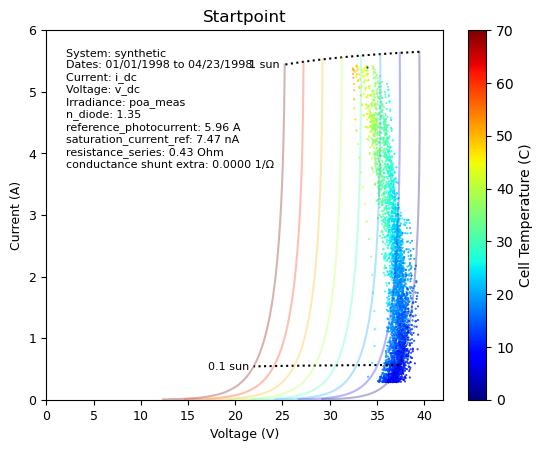

In [42]:
pvp.plot_Vmp_Imp_scatter(df=pvp.df[:5000],
                         p_plot=pvp.p0,
                         figure_number=4,
                         plot_vmp_max=42,
                         plot_imp_max=6)
plt.title('Startpoint')
plt.show()

Set boolean mask for which points to include. For this clean data, we are choosing a very simple mask. For a real PV dataset, more filtering on bad data is typically required.

In [43]:

boolean_mask = pvp.df['poa_meas'] > 100

Set hyperparameters for running model.

In [44]:
# Set hyperparameters for running model.
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    # 'solver': 'nelder-mead',
    'diode_factor': pvp.p0['diode_factor'],
    'days_per_run': 30,
    'iterations_per_year': 12,
    'save_figs': False,
    'verbose' : False,
    'saturation_current_multistart':[0.7,1.0,1.3],
#     'saturation_current_multistart':[1.0],
    'start_point_method': 'last',
    'save_figs_directory': 'figures',
    'plot_imp_max': 7,
    'plot_vmp_max': 35,
    'boolean_mask': boolean_mask,
    'singlediode_method':'fast'
}

In [45]:
ret = pvp.execute(iteration='all',
                  **hyperparams)

100%|██████████| 48/48 [00:21<00:00,  2.28it/s]

Elapsed time: 0.35 min


Get results

In [46]:
pfit = pvp.result['p']
# Optional: throw away high residual "bad fit" points.
# pfit = pfit[pfit['residual']< np.percentile(pfit['residual'],90)].copy()
pfit.dropna(inplace=True)
pfit.index = pfit['t_start']

In [47]:
pfit.head()

,t_start,t_end,diode_factor_est,photocurrent_ref_est,saturation_current_ref_est,resistance_series_ref_est,resistance_shunt_ref_est,conductance_shunt_extra_est,v_oc_ref_est,i_mp_ref_est,...,nNsVth_ref,i_sc_ref,v_oc_ref,i_mp_ref,v_mp_ref,p_mp_ref,i_x_ref,i_xx_ref,t_mean,t_years
t_start,,,,,,,,,,,,,,,,,,,,,
1998-01-01 07:45:00,1998-01-01 07:45:00,1998-01-31 07:45:00,1.016009,6.094698,1.382201e-10,0.647452,400.0,0.0,47.352863,5.683735,...,2.074969,6.040745,46.099609,5.710807,38.019974,217.124742,6.040488,4.245566,1998-01-16 07:45:00,1998.041068
1998-01-31 18:15:00,1998-01-31 18:15:00,1998-03-02 18:15:00,0.879358,6.113835,3.186043e-12,0.745509,400.0,0.0,46.016405,5.701581,...,2.074969,6.061406,45.452148,5.729619,37.699407,216.003246,6.061150,4.312119,1998-02-15 18:15:00,1998.123203
1998-03-03 04:45:00,1998-03-03 04:45:00,1998-04-02 04:45:00,0.961739,6.104817,4.180306e-11,0.665534,400.0,0.0,45.743390,5.693171,...,2.074969,6.053361,45.024414,5.722897,37.588180,215.113272,6.053121,4.364347,1998-03-18 04:45:00,1998.208077
1998-04-02 15:15:00,1998-04-02 15:15:00,1998-05-02 15:15:00,1.029411,6.102398,2.483583e-10,0.600744,400.0,0.0,45.566879,5.690915,...,2.074969,6.040806,44.636719,5.710839,37.301823,213.024719,6.040556,4.372632,1998-04-17 15:15:00,1998.290212
1998-05-03 01:45:00,1998-05-03 01:45:00,1998-06-02 01:45:00,0.997089,6.063851,8.238116e-11,0.634597,400.0,0.0,44.878353,5.654968,...,2.074969,6.023872,44.446289,5.690411,36.925222,210.119677,6.023581,4.312808,1998-05-18 01:45:00,1998.375086


Inspect fit result

In [48]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvp.plot_Vmp_Imp_scatter(df=pvp.df[cax][mask],
                             p_plot=pfit.iloc[k],
                            plot_vmp_max=37,
                            plot_imp_max=7)
    plt.subplot(1,2,2)
    pvp.plot_current_irradiance_mpp_scatter(df=pvp.df[cax][mask],

                                            p_plot=pfit.iloc[k],
                            plot_imp_max=7)
    plt.show()

interactive(children=(IntSlider(value=24, description='k', max=48), Checkbox(value=True, description='filter')…

Analyze year-on-year trend.

In [49]:
yoy_result = analyze_yoy(pfit)

Format ground truth data for comparison.

In [50]:
compare = pvp.df.resample('M').mean()
compare['t_years'] = np.array(
            [t.year + (t.dayofyear - 1) / 365.25 for t in compare.index])


Compare results in a plot.

0.6102438025415354


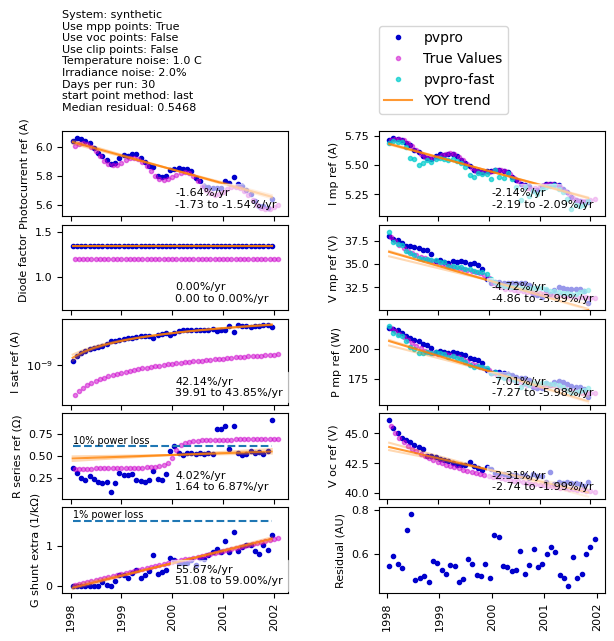

In [51]:
extra_text = 'System: {}\n'.format(pvp.system_name) + \
                 'Use mpp points: {}\n'.format(hyperparams['use_mpp_points']) + \
                 'Use voc points: {}\n'.format(hyperparams['use_voc_points']) + \
                 'Use clip points: {}\n'.format(hyperparams['use_clip_points']) + \
                 'Temperature noise: {} C\n'.format(temperature_noise_level) + \
                 'Irradiance noise: {:.1%} \n'.format(poa_noise_level) + \
                 'Days per run: {}\n'.format(hyperparams['days_per_run']) + \
                 'start point method: {}\n'.format(hyperparams['start_point_method']) + \
                 'Median residual: {:.4f}\n'.format(1000*np.median(pfit['residual']))



# Plot results
plot_results_timeseries(pfit,yoy_result=yoy_result,
                        extra_text=extra_text,
                        compare=compare)
# plt.savefig('figures/synth02_result.pdf',bbox_inches='tight')

Form comparison using rms error from extracted to true. 

In [62]:
from pvpro.postprocess import calculate_rms_error

In [63]:
rms_error = calculate_rms_error(pfit,df,zero_mean=True)

Inspect

In [64]:
pd.Series(rms_error)

diode_factor               1.199178e-16
photocurrent_ref           1.903264e-02
saturation_current_ref     3.898788e-09
resistance_series_ref      1.315753e-01
conductance_shunt_extra    1.364663e-04
resistance_shunt_ref       0.000000e+00
nNsVth_ref                 1.949488e-16
i_sc_ref                   1.826793e-02
v_oc_ref                   1.829607e-01
i_mp_ref                   1.008096e-02
v_mp_ref                   6.720123e-01
p_mp_ref                   3.757021e+00
dtype: float64